## NYのAirbnb物件数の要因分析

* このノートブックは2019年12月11日に開催された「[マッピング&ロケーション 開発 最前線](https://www.esrij.com/events/details/120076/)」でのデモンストレーション用に米国 Esri が[サンプルとして公開しているノートブック](https://developers.arcgis.com/python/sample-notebooks/analyzing-growth-factors-of-airbnb-properties-in-new-york-city/)を一部改変したものです。
* 改変した主な箇所は以下のとおりです
    * Spatial DataFrame ではなく Spatially Enabled DataFrame を使用しました ([詳細](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/))
    * ランダムフォレストによる解析は割愛しました
    * 勾配ブースティングのハイパーパラメーターの探索にグリッドサーチを用いました
    * 学習モデルの結果を可視化する際、トレーニングデータと検証用データの比較には棒グラフを用いました
* 使用されたデータの出所は[データソース一覧](https://developers.arcgis.com/python/sample-notebooks/analyzing-growth-factors-of-airbnb-properties-in-new-york-city/#Data-resources-)をご参照ください。
* このノートブックの実行には以下のパッケージ及びそれらの依存するパッケージが必要です。
    * arcgis 1.7.0
    * seaborn 0.9.0
    * scikit-learn 0.21.1
    * joblib 0.14.0

### 目次
- [必要なモジュールのインポート](#必要なモジュールのインポート)
- [マップによるデータの可視化](#マップによるデータの可視化)
- [Airbnb物件の数を統計調査区域で集計](#Airbnb物件の数を統計調査区域で集計)
- [ジオエンリッチメントで不足しているデータを追加](#ジオエンリッチメントで不足しているデータを追加)
- [ArcGIS Onlineの解析サービスを利用し、その他必要なデータを作成](#ArcGIS-Onlineの解析サービスを利用し、その他必要なデータを作成)
- [作成したデータを結合](#作成したデータを結合)
- [機械学習モデル (勾配ブースティング) による要因分析](#機械学習モデル-(勾配ブースティング)-による要因分析)
- [matplotlibとseabornによる結果の可視化](#matplotlibとseabornによる結果の可視化)

### 必要なモジュールのインポート

In [2]:
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from IPython.core.pylabtools import figsize

# データ処理
import pandas as pd
import numpy as np

# 機械学習
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.externals import joblib

In [3]:
# ArcGIS API for Python
import arcgis
from arcgis.geoenrichment import Country
from arcgis.features import summarize_data
from arcgis.features.enrich_data import enrich_layer
from arcgis.features import GeoAccessor
from arcgis.features import use_proximity 
from arcgis.gis import GIS

In [25]:
# アイテム識別用にタイトルにつける日付
today = "20191208"

# ArcGIS Onlineのクレデンシャル
user = "ユーザーネーム"
portal = "ArcGIS Online または ArcGIS Enterprise のURL"

In [13]:
gis = GIS(url = portal, username = user)

Enter password: ········


### マップによるデータの可視化

<Item title:"NYCTractData" type:Feature Layer Collection owner:nakamura_dev_org>
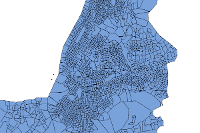

In [14]:
# NYの統計調査区域
nyc_tract_full = gis.content.search("NYCTractData", item_type = "feature layer")[0]
nyc_tract_full

In [15]:
# レイヤー
nyc_tracts_layer = nyc_tract_full.layers[0]

<Item title:"AnBNYC2019" type:Feature Layer Collection owner:nakamura_dev_org>
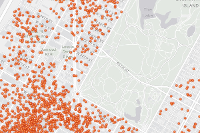

In [16]:
# 2019年のAirbnbの物件データ
airbnb_nyc2019 = gis.content.search("AnBNYC2019", item_type = "feature layer")[0]
airbnb_nyc2019

In [17]:
# レイヤー
airbnb_layer = airbnb_nyc2019.layers[0]

In [19]:
# NYの統計調査区域のプロット
m_ny = gis.map("New York City")
m_ny.add_layer(nyc_tracts_layer)
m_ny

In [21]:
# Airbnb物件
m_airbnb = gis.map("Springfield Gardens, NY")
m_airbnb.add_layer(airbnb_layer)
m_airbnb

In [22]:
# Spatially Enabled DataFrameの作成
pd.set_option("display.max_columns", 110)
sedf_airbnb_layer = pd.DataFrame.spatial.from_layer(airbnb_layer)
sedf_airbnb_layer.head(2)

OBJECTID                                              SHAPE  \
0         1  {'x': -8235507.210899999, 'y': 4964733.1453000...   
1         2  {'x': -8231847.026000001, 'y': 4983593.6740999...   

                                       access  accommodat  airbnb  \
0                                                       4       1   
1  Everything in the studio is for their use.           3       1   

                                           amenities  availabi_1  availabi_2  \
0  {TV,"Cable TV",Internet,Wifi,"Air conditioning...           0           0   
1  {TV,"Cable TV",Wifi,"Air conditioning","Paid p...          28          43   

   availabi_3  availabili  bathrooms  bed_type  bedrooms  beds  calculat_1  \
0           0           0        2.0  Real Bed         2     2           1   
1         296           8        1.0  Real Bed         0     2           1   

   calculat_2  calculat_3  calculated calendar_l    calendar_u  \
0           1           0           2 2019-06-03   4 weeks ago   
1           1           0           2 2019-06-03  7 months ago   

                    cancellati      city cleaning_f        country country_co  \
0                     moderate  Brooklyn     $60.00  United States         US   
1  strict_14_with_grace_period  New York     $60.00  United States         US   

                                          descriptio experience extra_peop  \
0  Imagine a quiet, spacious apartment, with beau...       none      $0.00   
1  Comfortable, spacious studio in one of the mos...       none     $25.00   

  first_revi  guests_inc has_availa host_accep host_has_p host_ident  \
0 2011-05-29           2          t        N/A          t          t   
1 2011-05-30           1          t        N/A          t          f   

  host_is_su  host_listi                         host_locat  host_neigh  \
0          t           2  New York, New York, United States  Park Slope   
1          f           2  New York, New York, United States      Harlem   

  host_res_1      host_respo host_since  host_total  \
0       100%    within a day 2011-05-22           2   
1       100%  within an hour 2011-05-23           2   

                                          house_rule      id instant_bo  \
0  No pets, no smoking. The $25/night for each gu...  121861          f   
1  no loud music no pets  no children $300 dollar...  123784          t   

                         interactio is_busines is_locatio jurisdicti  \
0                                            f          t              
1  As much as the guest would like.          f          t              

  last_revie last_scrap  latitude license  longitude    market  maximum__1  \
0 2016-05-02 2019-06-03  40.67644          -73.98082  New York       730.0   
1 2019-05-17 2019-06-03  40.80481          -73.94794  New York       365.0   

   maximum_ma  maximum_mi  maximum_ni  minimum__1  minimum_ma  minimum_mi  \
0         730           2         730         2.0         730           2   
1         365           2         365         2.0         365           2   

   minimum_ni monthly_pr                                 name  \
0           2             Park Slope Apt:, Spacious 2 bedroom   
1           2  $3,200.00     NYC Studio for Rent in Townhouse   

                                          neighborho  neighbou_1 neighbou_2  \
0                                                     Park Slope   Brooklyn   
1  The new restaurants, stores and cafes. Everyth...      Harlem  Manhattan   

  neighbourh                                              notes  number_of1  \
0   Brooklyn                                                              0   
1     Harlem  45.00 dollar fee for air-conditioner in the su...          42   

   number_of_  price property_t require__1 require_gu requires_l  review_s_1  \
0          23    165  Apartment          f          f          f          10   
1         138    110  Apartment          t          t          f          10   

   review_

### Airbnb物件の数を統計調査区域で集計
各統計調査区域内のAirbnb物件の数を集計します。解析にはArcGIS Onlineのクレジットを使用します。

In [15]:
# estimate = True を引数に追加するとクレジット使用量の推計が可能です。
agg_result = summarize_data.aggregate_points(point_layer = airbnb_layer,
                                             polygon_layer = nyc_tracts_layer,
                                             output_name = "airbnb_counts_{0}".format(today))

<Item title:"airbnb_counts_20191208" type:Feature Layer Collection owner:nakamura_dev_org>
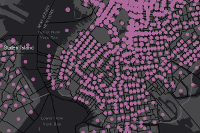

In [27]:
agg_result

In [28]:
# 集計結果の可視化
agg_map = gis.map("New York city", zoomlevel = 9)
agg_map.basemap = "dark-gray-vector"
agg_map

MapView(layout=Layout(height='400px', width='100%'), zoom=9.0)

In [29]:
# 集計されたポイント数が多い地区を濃い色で塗り分けて表示
agg_map.add_layer(agg_result, {"renderer": "ClassedColorRenderer", "field_name": "Point_Count"})

In [30]:
# Spatially enabled dataframe に変換
# Point_Countを目的変数として解析する
sedf_airbnb_count = GeoAccessor.from_layer(agg_result.layers[0])
sedf_airbnb_count.sort_values("Point_Count", ascending = False).head()

AnalysisArea  OBJECTID  Point_Count  \
420      0.067319       421          354   
414      0.067192       415          326   
319      0.084048       320          315   
325      0.078139       326          296   
416      0.313710       417          286   

                                                 SHAPE Shape__Area  \
420  {'rings': [[[-8236677.6738, 4977787.5451], [-8...        None   
414  {'rings': [[[-8236880.6092, 4977419.5198], [-8...        None   
319  {'rings': [[[-8236251.2084, 4971803.5636], [-8...        None   
325  {'rings': [[[-8236728.9918, 4972068.9934], [-8...        None   
416  {'rings': [[[-8238294.1446, 4978204.6766], [-8...        None   

     Shape__Area_2 Shape__Length  Shape__Length_2   aland  awater countyfp  \
420   3.042437e+05          None      2288.071832  174356       0      061   
414   3.036467e+05          None      2286.963358  174026       0      061   
319   3.794066e+05          None      2564.176975  217682       0      061   
325   3.527526e+05          None      2350.196744  202380       0      061   
416   1.417800e+06          None      5000.607501  404996  407508      061   

    funcstat        geoid     intptlat      intptlon  mtfcc name  \
420        S  36061013300  +40.7647381  -073.9880352  G5020  133   
414        S  36061012700  +40.7622370  -073.9898560  G5020  127   
319        S  36061003200  +40.7255579  -073.9837166  G5020   32   
325        S  36061003800  +40.7273669  -073.9884656  G5020   38   
416        S  36061012900  +40.7650139  -073.9998117  G5020  129   

             namelsad statefp tractce  
420  Census Tract 133      36  013300  
414  Census Tract 127      36  012700  
319   Census Tract 32      36  003200  
325   Census Tract 38      36  003800  
416  Census Tract 129      36  012900

### ジオエンリッチメントで不足しているデータを追加

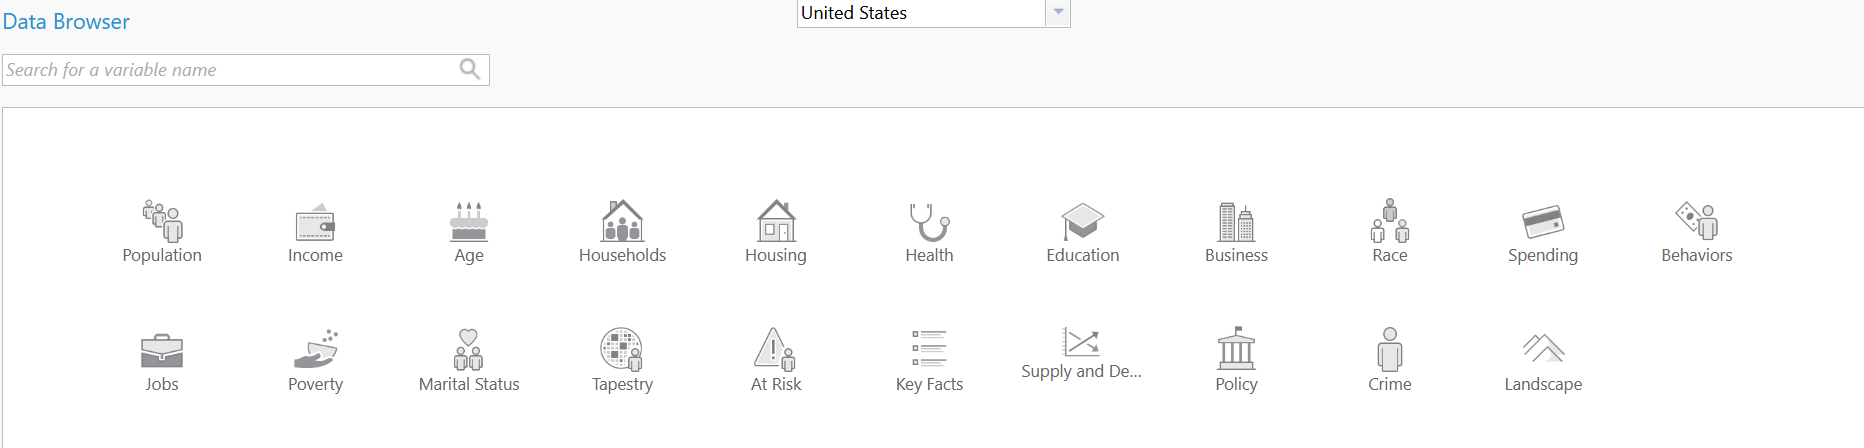

In [31]:
# Esriが提供するデータから米国で使用可能なものを検索
usa = Country.get("US")
usa_data = usa.data_collections
df_usa_data = pd.DataFrame(usa_data)
df_usa_data.head()

analysisVariable                   alias  \
dataCollectionID                                                    
1yearincrements   1yearincrements.AGE0_CY  2019 Population Age <1   
1yearincrements   1yearincrements.AGE1_CY   2019 Population Age 1   
1yearincrements   1yearincrements.AGE2_CY   2019 Population Age 2   
1yearincrements   1yearincrements.AGE3_CY   2019 Population Age 3   
1yearincrements   1yearincrements.AGE4_CY   2019 Population Age 4   

                                       fieldCategory vintage  
dataCollectionID                                              
1yearincrements   2019 Age: 1 Year Increments (Esri)    2019  
1yearincrements   2019 Age: 1 Year Increments (Esri)    2019  
1yearincrements   2019 Age: 1 Year Increments (Esri)    2019  
1yearincrements   2019 Age: 1 Year Increments (Esri)    2019  
1yearincrements   2019 Age: 1 Year Increments (Esri)    2019

In [23]:
# dataCollectionID列のユニークな値でフィルタリング
df_usa_data.reset_index(inplace = True)
list(df_usa_data.dataCollectionID.unique())

['1yearincrements',
 '5yearincrements',
 'ACS_Housing_Summary_rep',
 'ACS_Population_Summary_rep',
 'Age',
 'AgeDependency',
 'Age_50_Profile_rep',
 'Age_by_Sex_Profile_rep',
 'Age_by_Sex_by_Race_Profile_rep',
 'AtRisk',
 'AutomobilesAutomotiveProducts',
 'Automotive_Aftermarket_Expenditures_rep',
 'BabyProductsToysGames',
 'Business_Summary_rep',
 'CivicActivitiesPoliticalAffiliation',
 'ClothingShoesAccessories',
 'Community_Profile_rep',
 'DaytimePopulation',
 'Demographic_and_Income_Comparison_Profile_rep',
 'Demographic_and_Income_Profile_rep',
 'Disposable_Income_Profile_rep',
 'ElectronicsInternet',
 'Electronics_and_Internet_Market_Potential_rep',
 'Executive_Summary_rep',
 'Finances_Market_Potential_rep',
 'FinancialInsurance',
 'Financial_Expenditures_rep',
 'Generations',
 'Graphic_Profile_rep',
 'GroceryAlcoholicBeverages',
 'Health',
 'HealthPersonalCare',
 'HealthPersonalCareCEX',
 'Health_and_Beauty_Market_Potential_rep',
 'HistoricalHouseholds',
 'HistoricalHousing',
 '

In [33]:
# 変数名とデータの名称の対応
enrichment_variables = {
 "classofworker.ACSCIVEMP":                       "Employed Population Age 16+",
 "classofworker.ACSMCIVEMP":                      "Employed Male Pop Age 16+",
 "classofworker.ACSMPRIVNP":                      "Male 16+Priv Nonprofit",
 "classofworker.ACSMEPRIVP":                      "Male 16+:Priv Profit Empl",
 "classofworker.ACSMSELFI":                       "Male 16+:Priv Profit Self Empl",
 "classofworker.ACSMSTGOV":                       "Male 16+:State Govt Wrkr",
 "classofworker.ACSMFEDGOV":                      "Male 16+:Fed Govt Wrkr",
 "classofworker.ACSMSELFNI":                      "Male 16+:Self-Emp Not Inc",
 "classofworker.ACSMUNPDFM":                      "Male 16+:Unpaid Family Wrkr",              
 "classofworker.ACSFCIVEMP":                      "Female Pop Age 16+",
 "classofworker.ACSFEPRIVP":                      "Female 16+:Priv Profit Empl",
 "classofworker.ACSFSELFI":                       "Female 16+:Priv Profit Self Empl",                      
 "classofworker.ACSFPRIVNP":                      "Female 16+:Priv Nonprofit",
 "classofworker.ACSFLOCGOV":                      "Female 16+:Local Govt Wrkr",
 "classofworker.ACSFSTGOV":                       "Female 16+:State Govt Wrkr",
 "classofworker.ACSFFEDGOV":                      "Female 16+:Fed Govt Wrkr",                      
 "classofworker.ACSFSELFNI":                      "Female 16+:Self-Emp Not Inc",                      
 "classofworker.ACSFUNPDFM":                      "Female 16+:Unpaid Family Wrkr",                      
 "gender.MEDAGE_CY":                              "2019 Median Age",
 "Generations.GENALPHACY":                        "2019 Generation Alpha Population",
 "Generations.GENZ_CY":                           "2019 Generation Z Population",
 "Generations.MILLENN_CY":                        "2019 Millennial Population",
 "Generations.GENX_CY":                           "2019 Generation X Population",
 "Generations.BABYBOOMCY":                        "2019 Baby Boomer Population",
 "Generations.OLDRGENSCY":                        "2019 Silent & Greatest Generations Population",
 "Generations.GENBASE_CY":                        "2019 Population by Generation Base",
 "populationtotals.POPDENS_CY":                   "2019 Population Density",
 "DaytimePopulation.DPOP_CY":                     "2019 Total Daytime Population",
 "raceandhispanicorigin.WHITE_CY":                "2019 White Population",
 "raceandhispanicorigin.BLACK_CY":                "2019 Black Population",
 "raceandhispanicorigin.AMERIND_CY":              "2019 American Indian Population",
 "raceandhispanicorigin.ASIAN_CY":                "2019 Asian Population",
 "raceandhispanicorigin.PACIFIC_CY":              "2019 Pacific Islander Population",
 "raceandhispanicorigin.OTHRACE_CY":              "2019 Other Race Population",
 "raceandhispanicorigin.DIVINDX_CY":              "2019 Diversity Index",
 "households.ACSHHBPOV":                          "HHs: Inc Below Poverty Level",
 "households.ACSHHAPOV":                          "HHs:Inc at/Above Poverty Level",
 "households.ACSFAMHH":                           "ACS Family Households",
 "businesses.S01_BUS":                            "Total Businesses (SIC)",
 "businesses.N05_BUS":                            "Construction Businesses (NAICS)",
 "businesses.N08_BUS":                            "Retail Trade Businesses (NAICS)",
 "businesses.N21_BUS":                            "Transportation/Warehouse Bus (NAICS)",
 "ElectronicsInternet.MP09147a_B":                "Own any tablet",
 "ElectronicsInternet.MP09148a_B":                "Own any e-reader",
 "ElectronicsInternet.MP19001a_B":                "Have access to Internet at home",                
 "ElectronicsInternet.MP19070a_I":                "Index: Spend 0.5-0.9 hrs online(excl email/IM .",               
 "ElectronicsInternet.MP19071a_B":                "Spend <0.5 hrs online (excl email/IM time) daily",
 "populationtotals.TOTPOP_CY":                    "2019 Total Population",              
 "gender.MALES_CY":                               "2019 Male Population",
 "gender.FEMALES_CY":                             "2019 Female Population",
 "industry.EMP_CY":                               "2019 Employed Civilian Pop 16+",
 "industry.UNEMP_CY":                             "2019 Unemployed Population 16+",                     
 "industry.UNEMPRT_CY":                           "2019 Unemployment Rate",
 "commute.ACSWORKERS":                            "ACS Workers Age 16+",
 "commute.ACSDRALONE":                            "ACS Workers 16+: Drove Alone",
 "commute.ACSCARPOOL":                            "ACS Workers 16+: Carpooled",
 "commute.ACSPUBTRAN":                            "ACS Workers 16+: Public Transportation",
 "commute.ACSBUS":                                "ACS Workers 16+: Bus",
 "commute.ACSSTRTCAR":                            "ACS Workers 16+: Streetcar",
 "commute.ACSSUBWAY":                             "ACS Workers 16+: Subway",
 "commute.ACSRAILRD":                             "ACS Workers 16+: Railroad",
 "commute.ACSFERRY":                              "ACS Workers 16+: Ferryboat",
 "commute.ACSTAXICAB":                            "ACS Workers 16+: Taxicab",           
 "commute.ACSMCYCLE":                             "ACS Workers 16+: Motorcycle",
 "commute.ACSBICYCLE":                            "ACS Workers 16+: Bicycle",                             
 "commute.ACSWALKED":                             "ACS Workers 16+: Walked",
 "commute.ACSOTHTRAN":                            "ACS Workers 16+: Other Means",
 "commute.ACSWRKHOME":                            "ACS Wrkrs 16+: Worked at Home",
 "OwnerRenter.OWNER_CY":                          "2019 Owner Occupied HUs", 
 "OwnerRenter.RENTER_CY":                         "2019 Renter Occupied HUs", 
 "vacant.VACANT_CY":                              "2019 Vacant Housing Units", 
 "homevalue.MEDVAL_CY":                           "2019 Median Home Value",
 "housingunittotals.TOTHU_CY":                    "2019 Total Housing Units",
 "yearbuilt.ACSMEDYBLT":                          "ACS Median Year Structure Built: HUs",
 "SpendingTotal.X1001_X":                         "2019 Annual Budget Exp",
 "transportation.X6001_X":                        "2019 Transportation",
 "households.ACSTOTHH":                           "ACS Total Households",
 "DaytimePopulation.DPOPWRK_CY":                  "2019 Daytime Pop: Workers",
 "DaytimePopulation.DPOPRES_CY":                  "2019 Daytime Pop: Residents",
 "DaytimePopulation.DPOPDENSCY":                  "2019 Daytime Pop Density",
 "occupation.OCCPROT_CY":                         "2019 Occupation: Protective Service",
 "occupation.OCCFOOD_CY":                         "2019 Occupation: Food Preperation",
 "occupation.OCCPERS_CY":                         "2019 Occupation: Personal Care",
 "occupation.OCCADMN_CY":                         "2019 Occupation: Office/Admin",
 "occupation.OCCCONS_CY":                         "2019 Occupation: Construction/Extraction",
 "occupation.OCCPROD_CY":                         "2019 Occupation: Production"
}

In [34]:
# データフレーム化
enrichment_variables_df = pd.DataFrame.from_dict(enrichment_variables, orient = "index", columns = ["Variable Definition"])
enrichment_variables_df.reset_index(level = 0, inplace = True)
enrichment_variables_df.columns = ["AnalysisVariable", "Variable Definition"]
enrichment_variables_df.head()

AnalysisVariable             Variable Definition
0   classofworker.ACSCIVEMP     Employed Population Age 16+
1  classofworker.ACSMCIVEMP       Employed Male Pop Age 16+
2  classofworker.ACSMPRIVNP          Male 16+Priv Nonprofit
3  classofworker.ACSMEPRIVP       Male 16+:Priv Profit Empl
4   classofworker.ACSMSELFI  Male 16+:Priv Profit Self Empl

In [35]:
# ジオエンリッチメントのメソッドの引数に渡すためにリスト化
variable_names = enrichment_variables_df["AnalysisVariable"].tolist()

# リストの最初の4行をチェック
variable_names[1:5]

['classofworker.ACSMCIVEMP',
 'classofworker.ACSMPRIVNP',
 'classofworker.ACSMEPRIVP',
 'classofworker.ACSMSELFI']

<font color="red">次のセルの処理は大量にクレジットを消費するため注意してください</font>

estimate=True を引数に追加することで消費クレジットの推計が可能です。消費量が多すぎると感じる場合はジオエンリッチメントで付加するデータの数を減らしてください。


In [30]:
# ジオエンリッチメントの実行
airbnb_count_by_tract_enriched = enrich_layer(airbnb_count_by_tract,
                                              analysis_variables = variable_names,
                                              output_name = "airbnb_tract_enrich1_{0}".format(today))

{"messageCode": "AO_100047", "message": "Enrichment may not be available for some features."}
{"messageCode": "AO_100000", "message": "Unable to detect country for study area at [36]."}
{"messageCode": "AO_100000", "message": "Unable to detect country for study area at [40]."}


In [38]:
# Spatially Enabled DataFrameへ変換
sedf_enriched = GeoAccessor.from_layer(airbnb_count_by_tract_enriched.layers[0])

In [39]:
# DataFrameを確認
print(sedf_enriched.columns)
sedf_enriched_sorted = sedf_enriched.sort_values("geoid")
sedf_enriched_sorted.head()

Index(['ACSBICYCLE', 'ACSBUS', 'ACSCARPOOL', 'ACSCIVEMP', 'ACSDRALONE',
       'ACSFAMHH', 'ACSFCIVEMP', 'ACSFEPRIVP', 'ACSFERRY', 'ACSFFEDGOV',
       ...
       'geoid', 'intptlat', 'intptlon', 'mtfcc', 'name', 'namelsad',
       'populationToPolygonSizeRating', 'sourceCountry', 'statefp', 'tractce'],
      dtype='object', length=113)


ACSBICYCLE  ACSBUS  ACSCARPOOL  ACSCIVEMP  ACSDRALONE  ACSFAMHH  \
691         0.0     0.0         0.0        0.0         0.0       0.0   
693         0.0   287.0       173.0     1858.0       951.0    1013.0   
697        10.0   427.0       224.0     2917.0      1257.0    1497.0   
701         0.0   538.0       113.0     2120.0       759.0    1470.0   
705        12.0   142.0        32.0     1290.0       251.0     495.0   

     ACSFCIVEMP  ACSFEPRIVP  ACSFERRY  ACSFFEDGOV  ACSFLOCGOV  ACSFPRIVNP  \
691         0.0         0.0       0.0         0.0         0.0         0.0   
693       718.0       427.0       0.0        27.0       101.0        65.0   
697      1349.0       794.0       0.0        24.0       299.0       163.0   
701      1284.0       801.0       0.0        18.0       329.0        74.0   
705       627.0       372.0       0.0         4.0        92.0        97.0   

     ACSFSELFI  ACSFSELFNI  ACSFSTGOV  ACSFUNPDFM  ACSHHAPOV  ACSHHBPOV  \
691        0.0         0.0        0.0         0.0        0.0        0.0   
693       17.0        49.0       32.0         0.0     1021.0      300.0   
697       23.0        35.0       11.0         0.0     1696.0      239.0   
701       10.0        52.0        0.0         0.0     1405.0      557.0   
705       10.0        12.0       40.0         0.0      687.0      282.0   

     ACSMCIVEMP  ACSMCYCLE  ACSMEDYBLT  ACSMEPRIVP  ACSMFEDGOV  ACSMPRIVNP  \
691         0.0        0.0         0.0         0.0         0.0         0.0   
693      1140.0        0.0      1962.0       758.0        37.0        87.0   
697      1568.0        0.0      1999.0       823.0        40.0       128.0   
701       836.0        0.0      1973.0       525.0         0.0        45.0   
705       663.0        0.0      1954.0       440.0        13.0        53.0   

     ACSMSELFI  ACSMSELFNI  ACSMSTGOV  ACSMUNPDFM  ACSOTHTRAN  ACSPUBTRAN  \
691        0.0         0.0        0.0         0.0         0.0         0.0   
693       42.0        61.0       25.0         0.0         0.0       615.0   
697       30.0        83.0       15.0         0.0         0.0      1251.0   
701       50.0         0.0       65.0         0.0         0.0       991.0   
705        0.0        91.0       31.0         0.0        12.0       843.0   

     ACSRAILRD  ACSSTRTCAR  ACSSUBWAY  ACSTAXICAB  ACSTOTHH  ACSWALKED  \
691        0.0         0.0        0.0         0.0       0.0        0.0   
693        0.0         0.0      328.0        16.0    1321.0       71.0   
697       23.0         0.0      801.0         7.0    1935.0       46.0   
701        0.0         0.0      453.0         0.0    1962.0      154.0   
705       23.0        26.0      652.0         0.0     969.0       76.0   

     ACSWORKERS  ACSWRKHOME  AMERIND_CY  ASIAN_CY  AnalysisArea  BABYBOOMCY  \
691         0.0         0.0       110.0     194.0      1.044430       396.0   
693      1835.0         9.0        54.0     163.0      0.533681       876.0   
697      2848.0        53.0        52.0     155.0      0.585075      1168.0   
701      2098.0        81.0        54.0      78.0      0.187289      1205.0   
705      1250.0        24.0        23.0      32.0      1.074650       266.0   

     BLACK_CY  DIVINDX_CY  DPOPDENSCY  DPOPRES_CY  DPOPWRK_CY  DPOP_CY  \
691    6016.0        81.4       475.9         0.0       497.0    497.0   
693    1286.0        89.9      5823.5      2888.0       220.0   3108.0   
697    1925.0        90.4      6855.2      3470.0       541.0   4011.0   
701    2298.0        87.8     30304.3      3716.0      1960.0   5676.0   
705     642.0        89.6      7699.6      1143.0      7131.0   8274.0   

     EMP_CY  ENRICH_FID  FEMALES_CY  GENALPHACY  GENBASE_CY  GENX_CY  GENZ_CY  \
691     0.0       692.0       862.0         0.0     10471.0   3162.0   1599.0   
693  1795.0       694.0      2479.0       177.0      4638.0    915.0   1188.0   
697  2890.0       698.0      3231.0       246.0      6288.0   1372.0   1613.0   
701  2332.0       702.0      3365.0  

In [40]:
# ジオエンリッチメントで追加されたフィールド名をわかりやすい名称に変更する
enrichment_variables_copy = enrichment_variables_df.copy()
enrichment_variables_copy.head(2)

AnalysisVariable          Variable Definition
0   classofworker.ACSCIVEMP  Employed Population Age 16+
1  classofworker.ACSMCIVEMP    Employed Male Pop Age 16+

In [41]:
enrichment_variables_copy["AnalysisVariable"] = enrichment_variables_copy.AnalysisVariable.str.split(pat = ".", expand = True)[1]
enrichment_variables_copy

AnalysisVariable                       Variable Definition
0         ACSCIVEMP               Employed Population Age 16+
1        ACSMCIVEMP                 Employed Male Pop Age 16+
2        ACSMPRIVNP                    Male 16+Priv Nonprofit
3        ACSMEPRIVP                 Male 16+:Priv Profit Empl
4         ACSMSELFI            Male 16+:Priv Profit Self Empl
..              ...                                       ...
81       OCCFOOD_CY         2019 Occupation: Food Preperation
82       OCCPERS_CY            2019 Occupation: Personal Care
83       OCCADMN_CY             2019 Occupation: Office/Admin
84       OCCCONS_CY  2019 Occupation: Construction/Extraction
85       OCCPROD_CY               2019 Occupation: Production

[86 rows x 2 columns]

In [42]:
enrichment_variables_copy.set_index("AnalysisVariable", drop = True, inplace = True)
dictionary = enrichment_variables_copy.to_dict()
new_columns = dictionary["Variable Definition"]

In [43]:
# フィールド名を変更しDataFrameで確認
pd.set_option("display.max_columns", 150)
sedf_enriched_sorted.rename(columns = new_columns, inplace = True)
sedf_enriched_sorted.head()

ACS Workers 16+: Bicycle  ACS Workers 16+: Bus  \
691                       0.0                   0.0   
693                       0.0                 287.0   
697                      10.0                 427.0   
701                       0.0                 538.0   
705                      12.0                 142.0   

     ACS Workers 16+: Carpooled  Employed Population Age 16+  \
691                         0.0                          0.0   
693                       173.0                       1858.0   
697                       224.0                       2917.0   
701                       113.0                       2120.0   
705                        32.0                       1290.0   

     ACS Workers 16+: Drove Alone  ACS Family Households  Female Pop Age 16+  \
691                           0.0                    0.0                 0.0   
693                         951.0                 1013.0               718.0   
697                        1257.0                 1497.0              1349.0   
701                         759.0                 1470.0              1284.0   
705                         251.0                  495.0               627.0   

     Female 16+:Priv Profit Empl  ACS Workers 16+: Ferryboat  \
691                          0.0                         0.0   
693                        427.0                         0.0   
697                        794.0                         0.0   
701                        801.0                         0.0   
705                        372.0                         0.0   

     Female 16+:Fed Govt Wrkr  Female 16+:Local Govt Wrkr  \
691                       0.0                         0.0   
693                      27.0                       101.0   
697                      24.0                       299.0   
701                      18.0                       329.0   
705                       4.0                        92.0   

     Female 16+:Priv Nonprofit  Female 16+:Priv Profit Self Empl  \
691                        0.0                               0.0   
693                       65.0                              17.0   
697                      163.0                              23.0   
701                       74.0                              10.0   
705                       97.0                              10.0   

     Female 16+:Self-Emp Not Inc  Female 16+:State Govt Wrkr  \
691                          0.0                         0.0   
693                         49.0                        32.0   
697                         35.0                        11.0   
701                         52.0                         0.0   
705                         12.0                        40.0   

     Female 16+:Unpaid Family Wrkr  HHs:Inc at/Above Poverty Level  \
691                            0.0                             0.0   
693                            0.0                          1021.0   
697                            0.0                          1696.0   
701                            0.0                          1405.0   
705                            0.0                           687.0   

     HHs: Inc Below Poverty Level  Employed Male Pop Age 16+  \
691                           0.0                        0.0   
693                         300.0                     1140.0   
697                         239.0                     1568.0   
701                         557.0                      836.0   
705                         282.0                      663.0   

     ACS Workers 16+: Motorcycle  ACS Median Year Structure Built: HUs  \
691                          0.0                                   0.0   
693                          0.0                                1962.0   
697                          0.0                                1999.0   
701                          0.0                                1973.0   
705                          0.0                                1954.0   

     Male 1

### ArcGIS Onlineの解析サービスを利用し、その他必要なデータを作成

In [78]:
# NY市の各フィーチャ
busi_distr = gis.content.search("BusinessDistricts", "Feature Layer")[0]
cbd = gis.content.search("NYCBD", "Feature Layer")[0]
bus_stop = gis.content.search("NYCBusStop", "Feature Layer")[0]
hotels = gis.content.search("NYCHotels", "Feature Layer")[0]
railroad = gis.content.search("NYCRailroad", "Feature Layer")[0]
subwy_rt = gis.content.search("NYCSubwayRoutes", "Feature Layer")[0]
subwy_stn = gis.content.search("NYCSubwayStation", "Feature Layer")[0]

In [79]:
busi_distrs_lyr = busi_distr.layers[0] 
bus_stop_lyr = bus_stop.layers[0]
cbd_lyr = cbd.layers[0] 
hotels_lyr = hotels.layers[0]
railroad_lyr = railroad.layers[0]
subwy_stn_lyr =subwy_stn.layers[0]
subwy_rt_lyr = subwy_rt.layers[0] 

In [51]:
# 不要なwarningが出ないように設定
pd.set_option("mode.chained_assignment", None)

##### 一番近いホテルからの直線距離

In [64]:
tract_hotel_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                              hotels_lyr,
                                              measurement_type = "StraightLine",
                                              max_count = 1,
                                              output_name = "ny_tract_hotel_dist1_{0}".format(today))

In [46]:
# 可視化
hotel_dist_map = gis.map("New York city", zoomlevel = 9)
hotel_dist_map.basemap = "dark-gray-vector"
hotel_dist_map

MapView(layout=Layout(height='400px', width='100%'), zoom=9.0)

In [47]:
hotel_dist_map.add_layer(tract_hotel_dist)

In [48]:
tract_hotel_dist_lyr = tract_hotel_dist.layers[1]
sedf_tract_hotel_dist_lyr = pd.DataFrame.spatial.from_layer(tract_hotel_dist_lyr)
sedf_tract_hotel_dist_lyr.head()

From_ID From_Name From_Shape__Area  From_Shape__Area_2 From_Shape__Length  \
0        1       551             None       403498.199219               None   
1        2       552             None       291221.082031               None   
2        3       553             None       272297.578125               None   
3        4       554             None       294047.339844               None   
4        5      1187             None       326668.609375               None   

   From_Shape__Length_2 From_aland From_awater From_countyfp From_funcstat  \
0           2833.316907     231586           0           047             S   
1           2218.492564     167671           0           047             S   
2           2218.417869     156270           0           047             S   
3           2241.678034     169301           0           047             S   
4           2531.699227     187235           0           081             S   

    From_geoid From_intptlat From_intptlon From_mtfcc      From_namelsad  \
0  36047055100   +40.7139593  -073.9644095      G5020   Census Tract 551   
1  36047055200   +40.6083096  -073.9562588      G5020   Census Tract 552   
2  36047055300   +40.7164576  -073.9592358      G5020   Census Tract 553   
3  36047055400   +40.6078701  -073.9600716      G5020   Census Tract 554   
4  36081118700   +40.7596321  -073.8128802      G5020  Census Tract 1187   

  From_statefp From_tractce  NearRank  OBJECTID  \
0           36       055100         1         1   
1           36       055200         1         2   
2           36       055300         1         3   
3           36       055400         1         4   
4           36       118700         1         5   

                                               SHAPE  To_ACRES To_ADD_ADDR  \
0  {'paths': [[[-8233174.7694, 4970236.6078], [-8...         0               
1  {'paths': [[[-8233033.0714, 4955046.1346], [-8...         0               
2                                               None         0               
3  {'paths': [[[-8233360.5658, 4954998.8822], [-8...         0               
4  {'paths': [[[-8217285.2415, 4976923.7541], [-8...         0               

  To_ADD_CITY To_ADD_OWNER To_ADD_POBOX To_ADD_STATE To_ADD_ZIP To_AGDISTCODE  \
0                                                                               
1                                                                               
2                                                                               
3                                                                               
4                                                                               

  To_AGDISTNAME                                  To_BLDG_DESC To_BLDG_STYLE  \
0                Transient Occupancy - Midtown Manhattan Area            H3   
1                              Affordable Shared Room Housing            HR   
2                Transient Occupancy - Midtown Manhattan Area            H3   
3                              Affordable Shared Room Housing            HR   
4                                               Miscellaneous            H9   

   To_BOOK  To_CALC_ACRES To_COUNTY To_CT_NAME To_CT_SWIS  To_DEPTH  \
0        0       0.783712     Kings   Brooklyn     610100       222   
1        0       0.098448     Kings   Brooklyn     610100       100   
2        0       0.783712     Kings   Brooklyn     610100       222   
3        0       0.098448     Kings   Brooklyn     610100       100   
4        0       0.757880    Queens     Queens     630100       307   

  To_DUP_GEO  To_FRONT To_FUEL_DESC To_FUEL_TYPE  To_FULL_MV  To_GRID_EAST  \
0                  200                                     0        995656   
1                   40                                     0        993907   
2                  200                                     0        995656   
3                   40                                     0        993907   
4                  126                   

In [83]:
# 距離がマイルで算出されるため、メートルに換算
sedf_tract_hotel_dist_lyr_new = sedf_tract_hotel_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_hotel_dist_lyr_new["hotel_dist"] = round(sedf_tract_hotel_dist_lyr_new["Total_Miles"]*1609.344, 2)
sedf_tract_hotel_dist_lyr_new.sort_values('From_geoid').head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


From_geoid  Total_Miles  hotel_dist
691  36005000100     1.055256     1698.27
693  36005000200     1.039099     1672.27
697  36005000400     0.472664      760.68
701  36005001600     0.585977      943.04
705  36005001900     0.000000        0.00

##### バス停からの距離

In [65]:
tract_bustop_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                               bus_stop_lyr,
                                               measurement_type = "StraightLine",
                                               max_count = 1,
                                               output_name = "ny_tract_bus_stop_dist_{0}".format(today))

In [52]:
tract_bustop_dist_lyr = tract_bustop_dist.layers[1]
sedf_tract_bustop_dist_lyr = pd.DataFrame.spatial.from_layer(tract_bustop_dist_lyr)

In [53]:
sedf_tract_bustop_dist_lyr_new = sedf_tract_bustop_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_bustop_dist_lyr_new["busstop_dist"] = round(sedf_tract_bustop_dist_lyr_new["Total_Miles"]*1609.344, 2)
sedf_tract_bustop_dist_lyr_new.sort_values("From_geoid").head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From_geoid  Total_Miles  busstop_dist
691  36005000100     0.744344       1197.91
693  36005000200     0.005983          9.63
697  36005000400     0.000000          0.00
701  36005001600     0.000000          0.00
705  36005001900     0.000000          0.00

##### バス停の数を集計

In [70]:
num_bustops_tracts = summarize_data.aggregate_points(point_layer = bus_stop_lyr,
                                                     polygon_layer = nyc_tracts_layer,
                                                     output_name = "bustops_by_tracts_{0}".format(today))

In [55]:
# 可視化
bustop_map = gis.map("New York city", zoomlevel = 9)
bustop_map.basemap = "dark-gray-vector"
bustop_map

MapView(layout=Layout(height='400px', width='100%'), zoom=9.0)

In [58]:
bustop_map.add_layer(num_bustops_tracts, {"renderer": "ClassedSizeRenderer", "field_name": "Point_Count"})

In [57]:
# SEDFに変換し列名等を変更
num_bustops_tracts_lyr = num_bustops_tracts.layers[0]
sedf_num_bustops_tracts_lyr = pd.DataFrame.spatial.from_layer(num_bustops_tracts_lyr)

sedf_num_bustops_tracts_lyr_new = sedf_num_bustops_tracts_lyr[["geoid", "Point_Count"]] 
sedf_num_bustops_tracts_lyr_new = sedf_num_bustops_tracts_lyr_new.rename(columns={"Point_Count": "num_bustop"})
sedf_num_bustops_tracts_lyr_new.sort_values("geoid").head()

geoid  num_bustop
691  36005000100           0
693  36005000200           0
697  36005000400           1
701  36005001600           3
705  36005001900           2

##### CBDからの距離

In [85]:
tract_cbd_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                            cbd_lyr,
                                            measurement_type = "StraightLine",
                                            max_count = 1,
                                            output_name = "ny_tract_cbd_dist_{0}".format(today))

In [61]:
# SEDFに変換し列名等を変更
tract_cbd_dist_lyr = tract_cbd_dist.layers[1]
sedf_tract_cbd_dist_lyr = pd.DataFrame.spatial.from_layer(tract_cbd_dist_lyr)

sedf_tract_cbd_dist_lyr_new = sedf_tract_cbd_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_cbd_dist_lyr_new["cbd_dist"] = round(sedf_tract_cbd_dist_lyr_new["Total_Miles"]*1609.344, 2) 
sedf_tract_cbd_dist_lyr_new.sort_values("From_geoid").head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From_geoid  Total_Miles  cbd_dist
691  36005000100     4.999247   8045.51
693  36005000200     6.858514  11037.71
697  36005000400     7.321927  11783.50
701  36005001600     7.525535  12111.17
705  36005001900     4.333590   6974.24

##### 地下鉄の駅からの距離

In [91]:
tract_subwy_stn_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                  subwy_stn_lyr,
                                                  measurement_type = "StraightLine",
                                                  max_count = 1,
                                                  output_name = "ny_tract_subway_station_dist_{0}".format(today))

In [63]:
# SEDFに変換し列名等を変更
tract_subwy_stn_dist_lyr = tract_subwy_stn_dist.layers[1]
sedf_tract_subwy_stn_dist_lyr = pd.DataFrame.spatial.from_layer(tract_subwy_stn_dist_lyr)

In [65]:
sedf_tract_subwy_stn_dist_lyr_new = sedf_tract_subwy_stn_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_subwy_stn_dist_lyr_new["subwy_stn_dist"] = round(sedf_tract_subwy_stn_dist_lyr_new["Total_Miles"]*1609.344, 2) 
sedf_tract_subwy_stn_dist_lyr_new.sort_values("From_geoid").head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From_geoid  Total_Miles  subwy_stn_dist
691  36005000100     0.946226         1522.80
693  36005000200     1.108173         1783.43
697  36005000400     1.191505         1917.54
701  36005001600     0.729661         1174.28
705  36005001900     0.080063          128.85

##### 地下鉄の路線からの距離

In [95]:
tract_subwy_rt_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                 subwy_rt_lyr,
                                                 measurement_type = "StraightLine",
                                                 max_count = 1,
                                                 output_name = "ny_tract_subway_routes_dist_{0}".format(today))

In [67]:
# 可視化
subwy_rt_dist_map = gis.map("New York city", zoomlevel = 9)
subwy_rt_dist_map.basemap = "dark-gray-vector"
subwy_rt_dist_map

MapView(layout=Layout(height='400px', width='100%'), zoom=9.0)

In [68]:
subwy_rt_dist_map.add_layer(tract_subwy_rt_dist)

In [69]:
# SEDFに変換し列名等を変更
tract_subwy_rt_dist_lyr = tract_subwy_rt_dist.layers[1]
sedf_tract_subwy_rt_dist_lyr = pd.DataFrame.spatial.from_layer(tract_subwy_rt_dist_lyr)

sedf_tract_subwy_rt_dist_lyr_new = sedf_tract_subwy_rt_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_subwy_rt_dist_lyr_new["subwy_rt_dist"] = round(sedf_tract_subwy_rt_dist_lyr_new["Total_Miles"]*1609.344, 2) 
sedf_tract_subwy_rt_dist_lyr_new.sort_values("From_geoid").head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From_geoid  Total_Miles  subwy_rt_dist
691  36005000100     0.905310        1456.96
693  36005000200     1.108725        1784.32
697  36005000400     1.192022        1918.37
701  36005001600     0.724321        1165.68
705  36005001900     0.002853           4.59

##### 地下鉄以外の鉄道からの距離

In [102]:
tract_railroad_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                 railroad_lyr,
                                                 measurement_type = 'StraightLine',
                                                 max_count = 1,
                                                 output_name = 'tract_railroad_dist{0}'.format(today))

In [71]:
# SEDFに変換し列名等を変更
tract_railroad_dist_lyr = tract_railroad_dist.layers[1]
sedf_tract_railroad_dist_lyr = pd.DataFrame.spatial.from_layer(tract_railroad_dist_lyr)

sedf_tract_railroad_dist_lyr_new = sedf_tract_railroad_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_railroad_dist_lyr_new["railroad_dist"] = round(sedf_tract_railroad_dist_lyr_new["Total_Miles"]*1609.344, 2) 
sedf_tract_railroad_dist_lyr_new.sort_values("From_geoid").head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From_geoid  Total_Miles  railroad_dist
691  36005000100     0.403054         648.65
693  36005000200     0.215395         346.64
697  36005000400     0.708551        1140.30
701  36005001600     0.614506         988.95
705  36005001900     0.000000           0.00

##### ビジネス地区からの距離

In [107]:
tract_busi_distrs_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                      busi_distrs_lyr,
                                                      measurement_type = "StraightLine",
                                                      max_count = 1,
                                                      output_name = "tract_busi_distrs_dist{0}".format(today))

In [73]:
# SEDFに変換し列名等を変更
tract_busi_distrs_dist_lyr = tract_busi_distrs_dist.layers[1]
sedf_tract_busi_distrs_dist_lyr = pd.DataFrame.spatial.from_layer(tract_busi_distrs_dist_lyr)

sedf_tract_busi_distrs_dist_lyr_new = sedf_tract_busi_distrs_dist_lyr[["From_geoid", "Total_Miles"]]
sedf_tract_busi_distrs_dist_lyr_new["busi_distr_dist"] = round(sedf_tract_busi_distrs_dist_lyr_new["Total_Miles"]*1609.344, 2) 
sedf_tract_busi_distrs_dist_lyr_new.sort_values("From_geoid").head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From_geoid  Total_Miles  busi_distr_dist
691  36005000100     1.308636          2106.04
693  36005000200     1.292505          2080.09
697  36005000400     1.596395          2569.15
701  36005001600     1.237620          1991.76
705  36005001900     0.510611           821.75

##### 行政区 (マンハッタン、ブルックリン、クイーンズ 、ブロンクス、スタテンアイランド) の名前を付与

In [74]:
ny_tract_boro = gis.content.search("NYCTractBorough", "Feature Layer")[0]
ny_tract_boro_lyr = ny_tract_boro.layers[0]

sedf_ny_tract_boro_lyr = pd.DataFrame.spatial.from_layer(ny_tract_boro_lyr)
sedf_ny_tract_boro_lyr_new = sedf_ny_tract_boro_lyr[["geoid", "boro_name"]]
sedf_ny_tract_boro_lyr_new.sort_values("geoid").head()

geoid boro_name
0  36005000100     Bronx
2  36005000200     Bronx
5  36005000400     Bronx
7  36005001600     Bronx
9  36005001900     Bronx

### 作成したデータを結合

In [84]:
# 解析した距離のデータを結合
tract_merge_dist = sedf_tract_hotel_dist_lyr_new.\
                        merge(sedf_tract_subwy_rt_dist_lyr_new, on = "From_geoid").\
                        merge(sedf_tract_railroad_dist_lyr_new, on = "From_geoid").\
                        merge(sedf_tract_subwy_stn_dist_lyr_new, on = "From_geoid").\
                        merge(sedf_tract_busi_distrs_dist_lyr_new, on = "From_geoid").\
                        merge(sedf_tract_cbd_dist_lyr_new, on = "From_geoid")

In [85]:
# 必要な列のみ抽出し、列名を変更
tract_merge_dist_new = tract_merge_dist[["From_geoid",
                                         "hotel_dist",
                                         "subwy_rt_dist",
                                         "railroad_dist",
                                         "subwy_stn_dist",
                                         "busi_distr_dist",
                                         "cbd_dist"]]

tract_merge_dist_new = tract_merge_dist_new.rename(columns={"From_geoid":"geoid"})
tract_merge_dist_new.sort_values("geoid").head()

geoid  hotel_dist  subwy_rt_dist  railroad_dist  subwy_stn_dist  \
691  36005000100     1698.27        1456.96         648.65         1522.80   
693  36005000200     1672.27        1784.32         346.64         1783.43   
697  36005000400      760.68        1918.37        1140.30         1917.54   
701  36005001600      943.04        1165.68         988.95         1174.28   
705  36005001900        0.00           4.59           0.00          128.85   

     busi_distr_dist  cbd_dist  
691          2106.04   8045.51  
693          2080.09  11037.71  
697          2569.15  11783.50  
701          1991.76  12111.17  
705           821.75   6974.24

In [86]:
# バス停数のレイヤーに行政区の名前を結合
tract_merge_dist_new = tract_merge_dist_new.\
                            merge(sedf_num_bustops_tracts_lyr_new, on='geoid').\
                            merge(sedf_ny_tract_boro_lyr_new,on = 'geoid')

tract_merge_dist_new = tract_merge_dist_new.sort_values('geoid')
tract_merge_dist_new.head()

geoid  hotel_dist  subwy_rt_dist  railroad_dist  subwy_stn_dist  \
691  36005000100     1698.27        1456.96         648.65         1522.80   
693  36005000200     1672.27        1784.32         346.64         1783.43   
697  36005000400      760.68        1918.37        1140.30         1917.54   
701  36005001600      943.04        1165.68         988.95         1174.28   
705  36005001900        0.00           4.59           0.00          128.85   

     busi_distr_dist  cbd_dist  num_bustop boro_name  
691          2106.04   8045.51           0     Bronx  
693          2080.09  11037.71           0     Bronx  
697          2569.15  11783.50           1     Bronx  
701          1991.76  12111.17           3     Bronx  
705           821.75   6974.24           2     Bronx

In [87]:
# Airbnb物件の数を結合
sedf_airbnb_count_new = sedf_airbnb_count[["geoid","Point_Count"]]
sedf_airbnb_count_new = sedf_airbnb_count_new.rename(columns = {"Point_Count": "total_airbnb"})
sedf_airbnb_count_new.sort_values("geoid").head()

geoid  total_airbnb
691  36005000100             0
693  36005000200             0
697  36005000400            15
701  36005001600             1
705  36005001900            24

In [88]:
# airbnb物件の数とその他のSEDFを結合
tract_merge_dist_all = sedf_airbnb_count_new.merge(tract_merge_dist_new, on = "geoid")
tract_merge_dist_all.head()

geoid  total_airbnb  hotel_dist  subwy_rt_dist  railroad_dist  \
0  36047055100           234      137.50          36.78          35.77   
1  36047055200            13     2161.10           0.00           0.00   
2  36047055300           207        0.00           0.00         362.98   
3  36047055400             6     2146.88          44.22          33.91   
4  36081118700            12      525.76        1073.74         109.41   

   subwy_stn_dist  busi_distr_dist  cbd_dist  num_bustop boro_name  
0          447.50           784.34   4078.84           1  Brooklyn  
1            0.00             0.00  15766.60           3  Brooklyn  
2            0.00           749.91   4110.72           0  Brooklyn  
3           54.39             0.00  15768.61           5  Brooklyn  
4         1073.64           759.30  13746.37           2    Queens

In [89]:
tract_merge_dist_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 10 columns):
geoid              2167 non-null object
total_airbnb       2167 non-null int64
hotel_dist         2167 non-null float64
subwy_rt_dist      2167 non-null float64
railroad_dist      2167 non-null float64
subwy_stn_dist     2167 non-null float64
busi_distr_dist    2167 non-null float64
cbd_dist           2167 non-null float64
num_bustop         2167 non-null int64
boro_name          2167 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 186.2+ KB


In [90]:
# 行政区名のデータをダミー変数に変換
tract_merge_dist_final = pd.get_dummies(tract_merge_dist_all, columns=["boro_name"])
tract_merge_dist_final.head()

geoid  total_airbnb  hotel_dist  subwy_rt_dist  railroad_dist  \
0  36047055100           234      137.50          36.78          35.77   
1  36047055200            13     2161.10           0.00           0.00   
2  36047055300           207        0.00           0.00         362.98   
3  36047055400             6     2146.88          44.22          33.91   
4  36081118700            12      525.76        1073.74         109.41   

   subwy_stn_dist  busi_distr_dist  cbd_dist  num_bustop  boro_name_Bronx  \
0          447.50           784.34   4078.84           1                0   
1            0.00             0.00  15766.60           3                0   
2            0.00           749.91   4110.72           0                0   
3           54.39             0.00  15768.61           5                0   
4         1073.64           759.30  13746.37           2                0   

   boro_name_Brooklyn  boro_name_Manhattan  boro_name_Queens  \
0                   1                    0                 0   
1                   1                    0                 0   
2                   1                    0                 0   
3                   1                    0                 0   
4                   0                    0                 1   

   boro_name_Staten Island  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

#### ジオエンリッチメントで取得したデータを結合

In [91]:
# 不要な列を削除
sedf_enriched_sorted_new = sedf_enriched_sorted.drop(["AnalysisArea",
                                                      "ENRICH_FID",
                                                      "HasData",
                                                      "ID",
                                                      "OBJECTID",
                                                      "Point_Count",
                                                      "SHAPE",
                                                      "Shape__Area",
                                                      "Shape__Length",
                                                      "aggregationMethod",
                                                      "aland",
                                                      "apportionmentConfidence",
                                                      "awater",
                                                      "countyfp",
                                                      "funcstat",
                                                      "intptlat",
                                                      "intptlon",
                                                      "mtfcc",
                                                      "name",
                                                      "namelsad",
                                                      "populationToPolygonSizeRating",
                                                      "sourceCountry",
                                                      "statefp","tractce"], axis=1)

sedf_enriched_sorted_new.shape

(2167, 89)

In [92]:
# NaNがあるかチェック
row_with_null = sedf_enriched_sorted_new.isnull().any(axis = 1)
# NaNを持つ列をprint
sedf_enriched_sorted_new[row_with_null]

ACS Workers 16+: Bicycle  ACS Workers 16+: Bus  \
286                       NaN                   NaN   
690                       NaN                   NaN   

     ACS Workers 16+: Carpooled  Employed Population Age 16+  \
286                         NaN                          NaN   
690                         NaN                          NaN   

     ACS Workers 16+: Drove Alone  ACS Family Households  Female Pop Age 16+  \
286                           NaN                    NaN                 NaN   
690                           NaN                    NaN                 NaN   

     Female 16+:Priv Profit Empl  ACS Workers 16+: Ferryboat  \
286                          NaN                         NaN   
690                          NaN                         NaN   

     Female 16+:Fed Govt Wrkr  Female 16+:Local Govt Wrkr  \
286                       NaN                         NaN   
690                       NaN                         NaN   

     Female 16+:Priv Nonprofit  Female 16+:Priv Profit Self Empl  \
286                        NaN                               NaN   
690                        NaN                               NaN   

     Female 16+:Self-Emp Not Inc  Female 16+:State Govt Wrkr  \
286                          NaN                         NaN   
690                          NaN                         NaN   

     Female 16+:Unpaid Family Wrkr  HHs:Inc at/Above Poverty Level  \
286                            NaN                             NaN   
690                            NaN                             NaN   

     HHs: Inc Below Poverty Level  Employed Male Pop Age 16+  \
286                           NaN                        NaN   
690                           NaN                        NaN   

     ACS Workers 16+: Motorcycle  ACS Median Year Structure Built: HUs  \
286                          NaN                                   NaN   
690                          NaN                                   NaN   

     Male 16+:Priv Profit Empl  Male 16+:Fed Govt Wrkr  \
286                        NaN                     NaN   
690                        NaN                     NaN   

     Male 16+Priv Nonprofit  Male 16+:Priv Profit Self Empl  \
286                     NaN                             NaN   
690                     NaN                             NaN   

     Male 16+:Self-Emp Not Inc  Male 16+:State Govt Wrkr  \
286                        NaN                       NaN   
690                        NaN                       NaN   

     Male 16+:Unpaid Family Wrkr  ACS Workers 16+: Other Means  \
286                          NaN                           NaN   
690                          NaN                           NaN   

     ACS Workers 16+: Public Transportation  ACS Workers 16+: Railroad  \
286                                     NaN                        NaN   
690                                     NaN                        NaN   

     ACS Workers 16+: Streetcar  ACS Workers 16+: Subway  \
286                         NaN                      NaN   
690                         NaN                      NaN   

     ACS Workers 16+: Taxicab  ACS Total Households  ACS Workers 16+: Walked  \
286                       NaN                   NaN                      NaN   
690                       NaN                   NaN                      NaN   

     ACS Workers Age 16+  ACS Wrkrs 16+: Worked at Home  \
286                  NaN                            NaN   
690                  NaN                            NaN   

     2019 American Indian Population  2019 Asian Population  \
286                              NaN                    NaN   
690                              NaN                    NaN   

     2019 Baby Boomer Population  2019 Black Population  2019 Diversity Index  \
286                          NaN                    NaN                   NaN   
690                          NaN                    NaN                   NaN   

 

In [93]:
# NaN値の数の合計を確認
nan_test = sedf_enriched_sorted_new.drop(["geoid"], axis = 1)
np.isnan(nan_test).sum().sum()

172

In [94]:
# NaNを0で補完
sedf_enriched_sorted_fill = sedf_enriched_sorted_new.fillna(0)

# NaNの合計数の再確認
nan_test = sedf_enriched_sorted_fill.drop(["geoid"], axis = 1)
np.isnan(nan_test).sum().sum()

0

In [95]:
# 全て結合し、モデルに投入する最終的なDataFrameを作成
final_df = pd.merge(tract_merge_dist_final,
                    sedf_enriched_sorted_fill,
                    left_on = "geoid",
                    right_on = "geoid",
                    how = "left")

print(final_df.shape)
final_df.head()

(2167, 102)


geoid  total_airbnb  hotel_dist  subwy_rt_dist  railroad_dist  \
0  36047055100           234      137.50          36.78          35.77   
1  36047055200            13     2161.10           0.00           0.00   
2  36047055300           207        0.00           0.00         362.98   
3  36047055400             6     2146.88          44.22          33.91   
4  36081118700            12      525.76        1073.74         109.41   

   subwy_stn_dist  busi_distr_dist  cbd_dist  num_bustop  boro_name_Bronx  \
0          447.50           784.34   4078.84           1                0   
1            0.00             0.00  15766.60           3                0   
2            0.00           749.91   4110.72           0                0   
3           54.39             0.00  15768.61           5                0   
4         1073.64           759.30  13746.37           2                0   

   boro_name_Brooklyn  boro_name_Manhattan  boro_name_Queens  \
0                   1                    0                 0   
1                   1                    0                 0   
2                   1                    0                 0   
3                   1                    0                 0   
4                   0                    0                 1   

   boro_name_Staten Island  ACS Workers 16+: Bicycle  ACS Workers 16+: Bus  \
0                        0                     169.0                 156.0   
1                        0                       0.0                  80.0   
2                        0                      70.0                  55.0   
3                        0                      24.0                 170.0   
4                        0                      29.0                 181.0   

   ACS Workers 16+: Carpooled  Employed Population Age 16+  \
0                        77.0                       3135.0   
1                        31.0                       1606.0   
2                        12.0                       1954.0   
3                        49.0                       2082.0   
4                       103.0                       1102.0   

   ACS Workers 16+: Drove Alone  ACS Family Households  Female Pop Age 16+  \
0                         355.0                 1085.0              1462.0   
1                         372.0                  831.0               746.0   
2                          86.0                  491.0               958.0   
3                         366.0                 1045.0               963.0   
4                         256.0                  553.0               433.0   

   Female 16+:Priv Profit Empl  ACS Workers 16+: Ferryboat  \
0                        869.0                        39.0   
1                        557.0                         0.0   
2                        692.0                        24.0   
3                        658.0                         0.0   
4                        313.0                         0.0   

   Female 16+:Fed Govt Wrkr  Female 16+:Local Govt Wrkr  \
0                      19.0                        89.0   
1                       0.0                        55.0   
2                       8.0                        28.0   
3                      12.0                       102.0   
4                       5.0                        21.0   

   Female 16+:Priv Nonprofit  Female 16+:Priv Profit Self Empl  \
0                      158.0                              49.0   
1                      105.0                               0.0   
2                       71.0                              48.0   
3                      116.0                              27.0   
4                       57.0                               0.0   

   Female 16+:Self-Emp Not Inc  Female 16+:State Govt Wrkr  \
0                        214.0                        35.0   
1                         18.0                        11.0   
2                        102.0                         9.0   
3                         30.0  

In [96]:
# NaNの合計数の最終確認
nan_test = sedf_enriched_sorted_fill.drop(['geoid'], axis = 1)
np.isnan(nan_test).sum().sum()

0

In [160]:
# 保存しておく
final_df.to_csv(r"./final_df.csv", index = False)

---

### 機械学習モデル (勾配ブースティング) による要因分析

In [97]:
final_df = pd.read_csv(r"./final_df.csv")

In [98]:
# 説明変数
X = final_df.drop(['geoid','total_airbnb'], axis = 1)

# 応答変数(Airbnb物件の数)
y = pd.DataFrame(final_df['total_airbnb'])

In [44]:
# 学習データと検証データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 20)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

# 応答変数を1次元配列に変換
y_train_array = y_train.values.flatten()
y_test_array = y_test.values.flatten() 

print(y_train_array.shape)
print(y_test_array.shape)

(1950, 100)
(1950, 1)
(217, 100)
(217, 1)
(1950,)
(217,)


In [55]:
# グリッドサーチで学習率以外のハイパーパラメーターを探索
model = GradientBoostingRegressor(n_estimators = 3000)
parameters = {"max_depth": [3, 4, 5],
              "min_samples_leaf": [3, 5, 9, 17],
              "max_features": [1.0, 0.3, 0.1]}

gscv = GridSearchCV(model, parameters, verbose=10, n_jobs=-1, cv=4)
gscv.fit(X_train, y_train_array)
print("best score =", gscv.best_score_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 136 out of 144 | elapsed:  3.6min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  3.7min finished


best score = 0.8207486232410965


In [56]:
# 学習率の探索
model = gscv.best_estimator_
model.set_params(n_estimators = 10000)
parameters = {"learning_rate": [0.1, 0.05, 0.02, 0.01]}
gscv = GridSearchCV(model, parameters, verbose = 10, n_jobs = -1, cv = 4)
gscv.fit(X_train, y_train_array)
print("best score =", gscv.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   37.0s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.1min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  3.1min remaining:   43.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.2min finished


best score = 0.8234131724970285


In [58]:
# 保存
joblib.dump(gscv.best_estimator_, "grid_searched.pkl")

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\170_devseminar\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['grid_searched.pkl']

In [46]:
# 保存したモデルをロード
model_GB_nonscale = joblib.load("grid_searched.pkl")

In [47]:
# パラメータを微調整して最終的な学習モデルを作成
model_GB_nonscale.set_params(n_estimators = 1500, subsample = 0.5)

# モデルの学習
model_GB_nonscale.fit(X_train, y_train_array)

# 結果の出力 (train)
print("Test metrics for Gradient Boosting Regressor model using nonscaled data")

ypred_train = model_GB_nonscale.predict(X_train)
print("r-square_train: ", round(model_GB_nonscale.score(X_train, y_train_array), 2))

mse_train = metrics.mean_squared_error(y_train_array, ypred_train)
print("RMSE_train: ", round(np.sqrt(mse_train), 4))

mean_absolute_error_train = metrics.mean_absolute_error(y_train_array, ypred_train)
print("MAE_train: ", round(mean_absolute_error_train, 4))

# 結果の出力 (test)
print("\nTest metrics for Gradient Boosting Regressor model using nonscaled data")

ypred_test = model_GB_nonscale.predict(X_test)
print("r-square_test: ", round(model_GB_nonscale.score(X_test, y_test_array), 4))

mse_test = metrics.mean_squared_error(y_test_array, ypred_test)  
print("RMSE_test: ", round(np.sqrt(mse_test),4))

mean_absolute_error_test = metrics.mean_absolute_error(y_test_array, ypred_test)
print("MAE_test: ", round(mean_absolute_error_test, 4))

Test metrics for Gradient Boosting Regressor model using nonscaled data
r-square_train:  0.99
RMSE_train:  3.1741
MAE_train:  2.2892

Test metrics for Gradient Boosting Regressor model using nonscaled data
r-square_test:  0.8115
RMSE_test:  22.5897
MAE_test:  10.2828


### matplotlibとseabornによる結果の可視化

#### Airbnb物件の数の予測において重要だった変数を可視化

In [23]:
# 勾配ブースティングモデルにおいて重要だった変数
feature_imp_GB = model_GB_nonscale.feature_importances_
rel_feature_imp_GB = 100 * feature_imp_GB / max(feature_imp_GB)
rel_feature_imp_GB = pd.DataFrame({"features": list(X_train.columns),
                                   "rel_importance": rel_feature_imp_GB})
rel_feature_imp_GB = rel_feature_imp_GB.sort_values("rel_importance", ascending = False)
rel_feature_imp_GB.head()

features  rel_importance
5                           cbd_dist      100.000000
68        2019 Millennial Population       44.545338
12          ACS Workers 16+: Bicycle       34.950183
44           ACS Workers 16+: Subway       21.390988
61  2019 Generation Alpha Population       10.017466

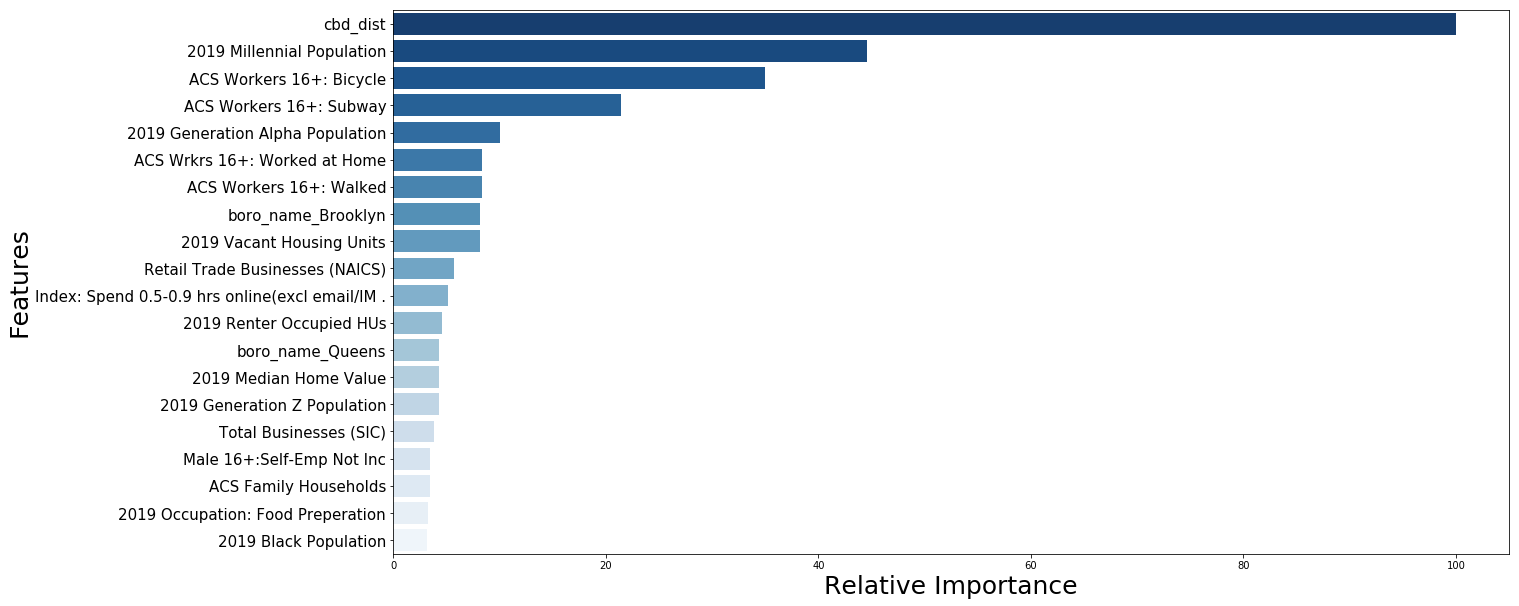

In [24]:
# チャートで確認
top20_features_GB = rel_feature_imp_GB.head(20) 

plt.figure(figsize = [20,10])
plt.yticks(fontsize = 15)
ax = sns.barplot(x = "rel_importance", y = "features", data = top20_features_GB, palette = "Blues_r")
plt.xlabel("Relative Importance", fontsize = 25)
plt.ylabel("Features", fontsize = 25)
plt.show()

In [31]:
# 交差検証
from sklearn.model_selection import cross_validate

y_array = y.values.flatten()
modelGB_cross_val = model_GB_nonscale.set_params(n_estimators = 1500, subsample = 0.5)
scores = cross_validate(model_GB_nonscale,
                        X,
                        y_array,
                        cv = 3,
                        scoring = {"neg_mean_absolute_error"},
                        return_train_score = True)

print(scores)

{'fit_time': array([11.26416 , 11.367725, 11.51113 ]), 'score_time': array([0.015632, 0.031279, 0.031249]), 'test_neg_mean_absolute_error': array([-15.855306, -12.455854, -10.571205]), 'train_neg_mean_absolute_error': array([-1.751932, -2.128536, -2.299245])}


#### testデータの統計調査区域別のAirbnb数の頻度分布

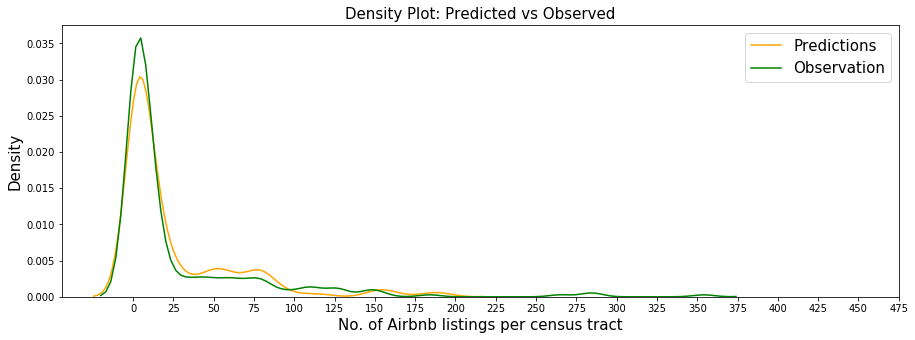

In [48]:
# グラフのサイズ指定
plt.figure(figsize=[15,5])

# 予測値のプロット
sns.kdeplot(ypred_test, label = 'Predictions', color = 'orange')
# 実測値のプロット
y_observed = np.array(y_test).reshape((-1, ))
sns.kdeplot(y_observed, label = 'Observation', color = 'green')

# ラベルの調整
plt.xlabel('No. of Airbnb listings per census tract', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Density Plot: Predicted vs Observed', fontsize=15)
plt.xticks(range(0,500,25), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)
plt.show()

#### testデータの統計調査区域別Airbnb物件数の比較

In [ ]:
# チャート作成用のDataFrame作成
barplot_df = y_test_df.reset_index()
barplot_df = barplot_df.rename(columns={"index": "test_data_index"})

# データ整形
barplot_df_melt = barplot_df.melt(id_vars = "test_data_index",
                                  value_name = "num_of_airbnb",
                                  value_vars = ["total_airbnb", "Predicted"],
                                  var_name = "Category")

# 整数値をカテゴリに変換
barplot_df_melt.test_data_index = barplot_df_melt.test_data_index.astype("category")
barplot_df_melt = barplot_df_melt.astype({"test_data_index": "category"})

In [256]:
# スタイル設定
sns.set(style="whitegrid")
# グラフのサイズ変更
f, ax = plt.subplots(figsize=(10, 90))
# プロット
sns.barplot(x = "num_of_airbnb",
            y = "test_data_index",
            data = barplot_df_melt,
            palette = "PuBuGn",
            ci = None,
            hue = "Category")

# ラベルの調整
plt.xlabel("Number of Airbnb", fontsize = 15)
plt.ylabel("Index of test dataset", fontsize = 15)
plt.title("Actual No. of Airbnb by Tract: Predicted vs Observed", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = "x-large", title_fontsize = "10")
plt.legend(fontsize = 15)
plt.show()